## Import your stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulators.faas.simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import rpy2.robjects.numpy2ri
from rpy2.robjects import rinterface, r, IntVector, FloatVector, StrVector
rpy2.robjects.numpy2ri.activate()
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 20

## Set up the prior

Last working prior
upper = np.array([7.700001e+08,  8.400001e+07,  3.200001e+10,  2.500001e+07,  1.600001e+05,
  2.600001e+03,  2.200001e+04,  6.500001e+00,  8.886492e+00,  7.924280e+00,
  1.050516e+01,  7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100001e-03, -3.900000e-01])
lower = np.array([7.700000e+08,  8.400000e+07,  3.200000e+10,  2.500000e+07,  1.600000e+05,
  2.600000e+03,  2.200000e+04,  6.500000e+00,  8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682372e+00, -4.509307e+00, -6.162728e+00,
 -6.585028e+00,  1.100000e-03, -3.900001e-01])

In [2]:
upper = np.array([12,  12,
  12,  12, -2, -2, -2,
 -2,  1.100001e-03, 0])
lower = np.array([6,  6,
  6,  6, -8, -8, -8,
 -8,  0, -3.900001e-01])
prior = priors.Uniform(lower, upper)

epsilon_lower = np.array([-0.1]*94)
epsilon_upper = np.array([0.1] * 94)
epsilon_prior = priors.Uniform(epsilon_lower, epsilon_upper)


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [3]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(theta, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.draw()
    
    return faasSimulator.simulation(np.concatenate([theta, eps]), seed)[:12,1:]

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0



## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
def compressor(d, compressor_args):
    comp_d = []
    
    for i in d:
        #mean of final ten entries
        final = np.mean(i[-10:])
        #median of 3 highest points
        peak = np.median(np.sort(i)[-3:])
        #time to peak
        time_peak = np.argmax(i == peak)
        sd = np.std(i[-10:])
        #time to final
        #time_final = np.argmax(np.logical_and((i >= final - sd),(i <= final + sd)) == True) + 1
        comp_d.append([final, peak, time_peak])# time_final])
    return np.asarray(comp_d).flatten()
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(faasSimulator.data()[:12], compressor_args)

print(compressed_data.shape)

(36,)


## Load in data

In [ ]:
data = faasSimulator.data()[:12,:]
print(data.shape)

## Define ensemble of NDEs

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=10, n_data=36, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=36, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=36, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=36, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=36, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=36, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [22]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
                       param_limits = [lower, upper],
                       param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
                       results_dir = "simulators/faas/results_batch_A/", save = True)

## Fisher pre-training to initialize the NDEs

## Sequential Neural Likelihood

In [ ]:
n_initial = 100
n_batch = 100
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20., save_intermediate_posteriors=False, simulator_args=simulator_args)

## Sample the learned posterior

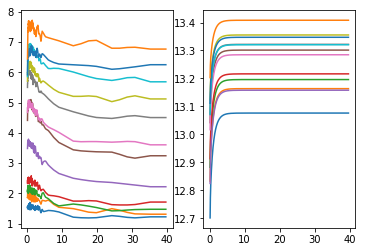

In [16]:
pst = np.load('simulators/faas/pst_samples_A.npy')
time = np.genfromtxt('simulators/faas/data/time_points.csv', delimiter=',')
sims = simulator(pst[1020], seed, simulator_args, 0)
data = faasSimulator.data()[:12,:]

fig,ax = plt.subplots(1,2) 

for i in range(len(sims)):
    ax[0].plot(time, data[i])
    ax[1].plot(time, sims[i])


plt.show()

In [20]:
print(np.unique(pst, axis=0).shape)

(300, 10)


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


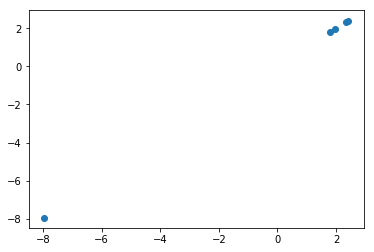

In [10]:
plt.scatter(np.log(pst[0,:]), np.log(pst[3,:]))
plt.show()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


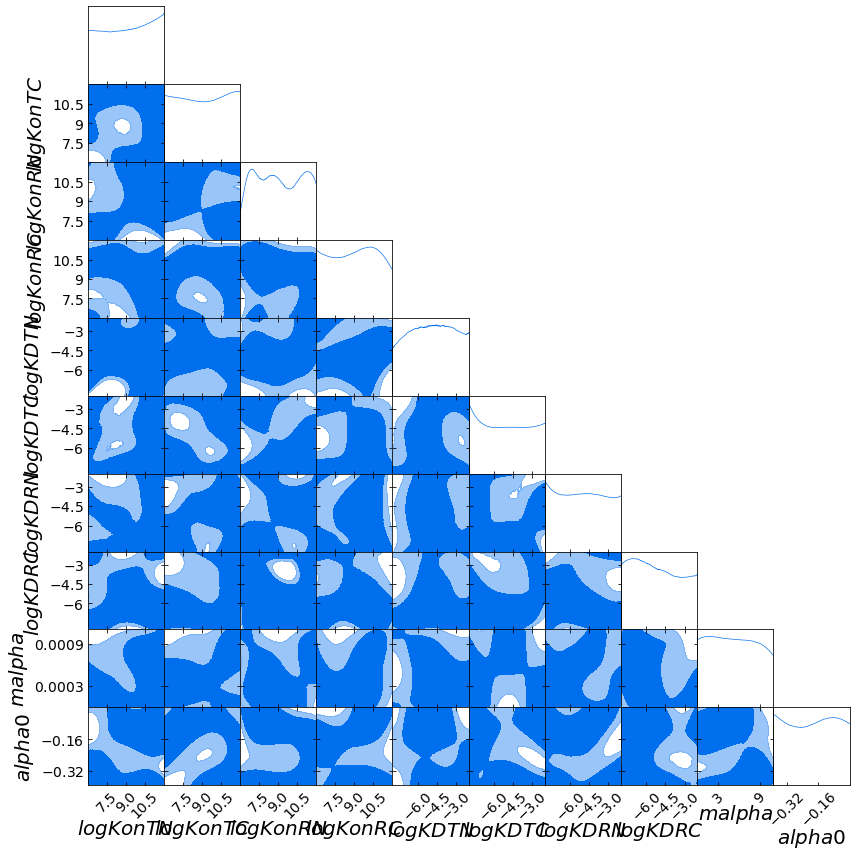

In [23]:
DelfiEnsemble.triangle_plot(samples=[np.unique(pst, axis=0)])

## Calibration

In [ ]:
rank = np.zeros(10,9)

for i in range(N):
    ps = prior.draw()
    sims = simulator(ps, 0, simulator_args, 1)
    DelfiEnsemble = delfi.Delfi(sims, prior, NDEs, 
                       param_limits = [lower, upper],
                       param_names = ['logK_on_TN', 'logK_on_TC', 'logK_on_RN', 'logK_on_RC', 'logK_D_TN', 'logK_D_TC', 'logK_D_RN', 'logK_D_RC', 'm_alpha', 'alpha0'],
                       results_dir = "simulators/faas/calib/", save = False)

    
    
    n_initial = 100
    n_batch = 10
    n_populations = 1

    DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=2., save_intermediate_posteriors=False, simulator_args=simulator_args)
    pst = DelfiEnsemble.emcee_sample()[:9]
    for j in range(18):
        for l in range(9):
            rank[j,l] += np.sum(pst[l][j] < ps[j])
        
    
        

